In [1]:
# Uncomment the following line when running on Google Colab
# !pip install autora

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from autora.cycle import Cycle
from autora.experimentalist.pipeline import Pipeline
from autora.experimentalist.pooler import grid_pool, poppernet_pool
from autora.experimentalist.sampler import nearest_values_sampler
from autora.skl.bms import BMSRegressor
from autora.variable import Variable, VariableCollection

In [3]:
# meta parameters
ground_truth_resolution = 1000
samples_per_cycle = 7
value_range = (-1, 5)
allowed_values = np.linspace(value_range[0], value_range[1], ground_truth_resolution)

In [4]:
# define ground truth
def ground_truth(xs):
    # return (xs ** 2.) + xs + 1.
    y = xs * 1.0
    y[xs < 0] = 0
    return y

In [5]:
# define variables
study_metadata = VariableCollection(
    independent_variables=[
        Variable(name="x1", allowed_values=allowed_values, value_range=value_range)
    ],
    dependent_variables=[Variable(name="y", value_range=(-20, 20))],
)

In [6]:
# define experiment platform
def get_synthetic_experiment_runner():
    rng = np.random.default_rng(seed=180)

    def runner(xs):
        return ground_truth(xs) + rng.normal(0, 0.5, xs.shape)

    return runner

synthetic_experiment_runner = get_synthetic_experiment_runner()

In [7]:
# Initialize the experimentalist
random_experimentalist = Pipeline(
    [
        ("grid_pool", grid_pool),  # type: ignore
        ("nearest_values_sampler", nearest_values_sampler),  # type: ignore
    ],
    {
        "grid_pool": {"ivs": study_metadata.independent_variables},
        "nearest_values_sampler": {
            "allowed_values": np.linspace(
                value_range[0], value_range[1], samples_per_cycle
            ),
            "n": samples_per_cycle,
        },
    },
)

In [8]:
# define theorist
bms_theorist = BMSRegressor(epochs=100)

In [9]:
# define seed cycle
# we will use this cycle to collect initial data and initialize the BMS model
seed_cycle = Cycle(
    metadata=study_metadata,
    theorist=bms_theorist,
    experimentalist=random_experimentalist,
    experiment_runner=synthetic_experiment_runner,
)

# run seed cycle
seed_cycle.run(num_cycles=1)

seed_model = seed_cycle.data.theories[0].model_
seed_x = seed_cycle.data.conditions[0]
seed_y = seed_cycle.data.observations[0][:, 1]

INFO:autora.skl.bms:BMS fitting started
  0%|          | 0/100 [00:00<?, ?it/s]<lambdifygenerated-56>:2: RuntimeWarning: invalid value encountered in power
  return X0**_a0_
<lambdifygenerated-118>:2: RuntimeWarning: divide by zero encountered in divide
  return _a0_/X0
<lambdifygenerated-119>:2: RuntimeWarning: divide by zero encountered in divide
  return _a0_/X0
  3%|▎         | 3/100 [00:00<00:03, 24.45it/s]<lambdifygenerated-203>:2: RuntimeWarning: divide by zero encountered in divide
  return sig(_a0_/X0)
/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-17yK3Jyq-py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<lambdifygenerated-204>:2: RuntimeWarning: divide by zero encountered in divide
  return sig(_a0_/X0)
<lambdifygenerated-205>:2: RuntimeWarning: divide by zero encountered in divide
  return sig(_a0_/X0)
<l

In [10]:
# now we define the poppernet experimentalist which takes into account
# the seed data and the seed model
popper_experimentalist = Pipeline(
    [
        ("popper_pool", poppernet_pool),  # type: ignore
        ("nearest_values_sampler", nearest_values_sampler),  # type: ignore
    ],
    {
        "popper_pool": {
            "metadata": study_metadata,
            "model": seed_model,
            "x_train": seed_x,
            "y_train": seed_y,
            "n": samples_per_cycle,
            "plot": True,
        },
        "nearest_values_sampler": {
            "allowed_values": allowed_values,
            "n": samples_per_cycle,
        },
    },
)

Finished training Popper Network...


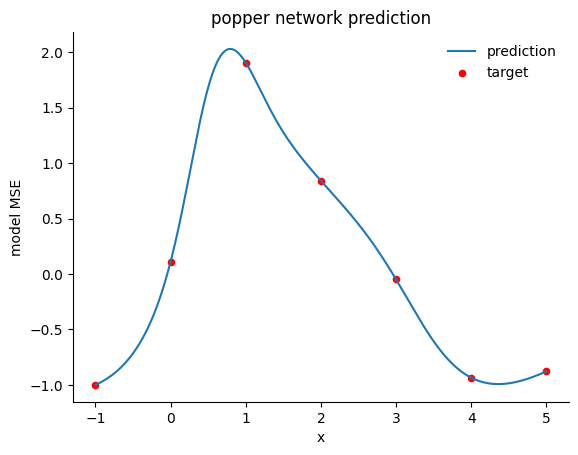

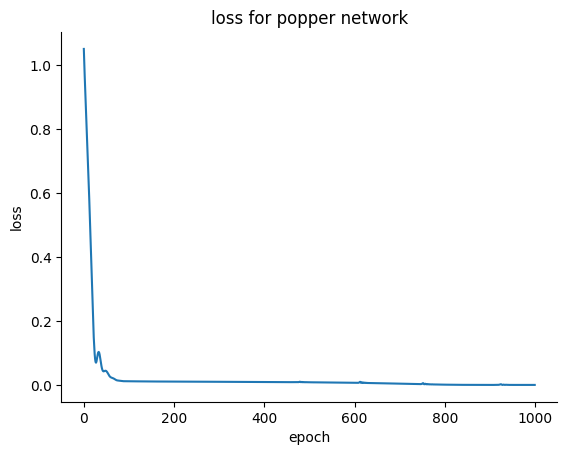

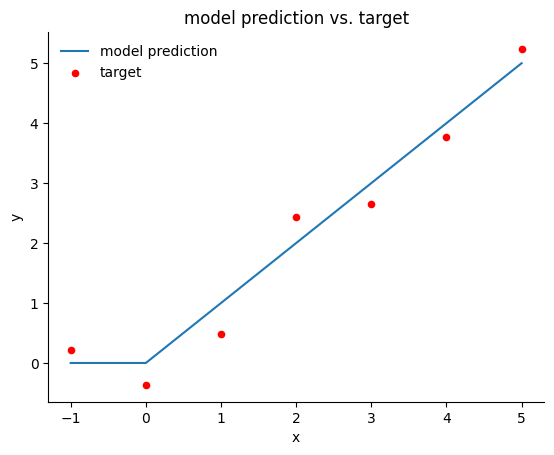

INFO:autora.skl.bms:BMS fitting started
  9%|▉         | 9/100 [00:00<00:03, 28.62it/s]<lambdifygenerated-3607>:2: RuntimeWarning: invalid value encountered in power
  return sig(_a0_**X0)
 21%|██        | 21/100 [00:00<00:02, 31.02it/s]/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-17yK3Jyq-py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 100/100 [00:03<00:00, 32.37it/s]
INFO:autora.skl.bms:BMS fitting finished


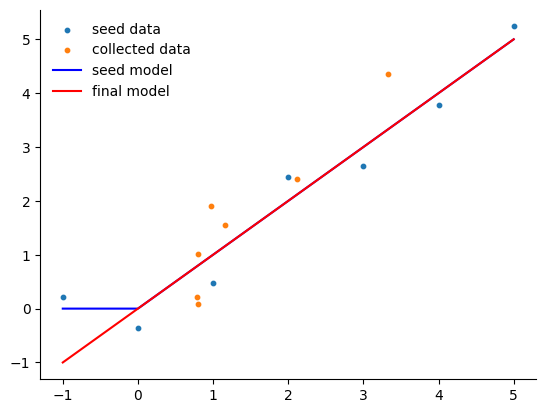

In [11]:
# running a new cycle taking into account the seed data and model
# TODO: need to find a way to incorporate the seed data into the cycle
cycle = Cycle(
    metadata=study_metadata,
    theorist=bms_theorist,
    experimentalist=popper_experimentalist,
    experiment_runner=synthetic_experiment_runner,
)
cycle.run(num_cycles=1)

# plot output of architecture search
all_obs = np.row_stack(seed_cycle.data.observations)
x_obs, y_obs = all_obs[:, 0], all_obs[:, 1]
plt.scatter(x_obs, y_obs, s=10, label="seed data")

all_obs = np.row_stack(cycle.data.observations)
x_obs, y_obs = all_obs[:, 0], all_obs[:, 1]
plt.scatter(x_obs, y_obs, s=10, label="collected data")

x_pred = np.array(study_metadata.independent_variables[0].allowed_values).reshape(
    ground_truth_resolution, 1
)
y_pred_seed = seed_cycle.data.theories[0].predict(x_pred)
y_pred_final = cycle.data.theories[0].predict(x_pred)
plt.plot(x_pred, y_pred_seed, color="blue", label="seed model")
plt.plot(x_pred, y_pred_final, color="red", label="final model")
plt.legend()
plt.show()
